<a href="https://colab.research.google.com/github/ccrespobarreda-ctrl/TFM/blob/main/Modelo_binario_de_Fracturas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))


CUDA available: True
Device: cuda


In [22]:
# =========================
# 1) Drive + Rutas + Checks
# =========================
from google.colab import drive
drive.mount("/content/drive")

import os, glob

# ✅ Tu estructura (según tu captura):
# Mi unidad / PROYECTOS DS / FRACTURAS /
PROJECT_ROOT = "/content/drive/MyDrive/PROYECTOS DS/FRACTURAS"

CSV_PATH = os.path.join(PROJECT_ROOT, "dataset.csv")
FRACTURED_DIR = os.path.join(PROJECT_ROOT, "Fractured")
NON_FRACTURED_DIR = os.path.join(PROJECT_ROOT, "Non_fractured")

def assert_exists(path, kind="file"):
    if kind == "file" and not os.path.isfile(path):
        raise FileNotFoundError(f"❌ No encuentro el archivo: {path}")
    if kind == "dir" and not os.path.isdir(path):
        raise FileNotFoundError(f"❌ No encuentro la carpeta: {path}")

assert_exists(CSV_PATH, "file")
assert_exists(FRACTURED_DIR, "dir")
assert_exists(NON_FRACTURED_DIR, "dir")

print("✅ CSV_PATH:", CSV_PATH)
print("✅ FRACTURED_DIR:", FRACTURED_DIR, "| n_imgs:", len(glob.glob(os.path.join(FRACTURED_DIR, "*"))))
print("✅ NON_FRACTURED_DIR:", NON_FRACTURED_DIR, "| n_imgs:", len(glob.glob(os.path.join(NON_FRACTURED_DIR, "*"))))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ CSV_PATH: /content/drive/MyDrive/PROYECTOS DS/FRACTURAS/dataset.csv
✅ FRACTURED_DIR: /content/drive/MyDrive/PROYECTOS DS/FRACTURAS/Fractured | n_imgs: 724
✅ NON_FRACTURED_DIR: /content/drive/MyDrive/PROYECTOS DS/FRACTURAS/Non_fractured | n_imgs: 3373


In [23]:
import shutil, os

LOCAL_ROOT = "/content/FRACTURAS"

if not os.path.exists(LOCAL_ROOT):  # evita copiar cada vez
    shutil.copytree(PROJECT_ROOT, LOCAL_ROOT)

print("Copiado a:", LOCAL_ROOT)

CSV_PATH = os.path.join(LOCAL_ROOT, "dataset.csv")
FRACTURED_DIR = os.path.join(LOCAL_ROOT, "Fractured")
NON_FRACTURED_DIR = os.path.join(LOCAL_ROOT, "Non_fractured")


Copiado a: /content/FRACTURAS


In [24]:
# Cargar el CSV
import pandas as pd

df = pd.read_csv(CSV_PATH)
df.head()

,image_id,hand,leg,hip,shoulder,mixed,hardware,multiscan,fractured,fracture_count,frontal,lateral,oblique
0,IMG0000000.jpg,0,1,0,0,0,0,1,0,0,1,1,0
1,IMG0000001.jpg,0,1,0,0,0,0,1,0,0,1,1,0
2,IMG0000002.jpg,0,1,0,0,0,0,1,0,0,1,1,0
3,IMG0000003.jpg,0,1,0,0,0,0,1,0,0,0,1,1
4,IMG0000004.jpg,0,1,0,0,0,0,1,0,0,0,1,1


In [25]:
# Ver cuántas imágenes hay por clase
print("Fracturadas:", len(os.listdir(FRACTURED_DIR)))
print("No fracturadas:", len(os.listdir(NON_FRACTURED_DIR)))

Fracturadas: 362
No fracturadas: 3373


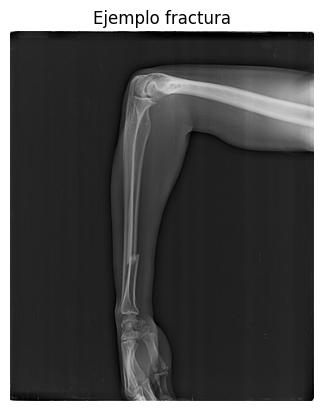

In [26]:
# Ver una imagen de ejemplo
from PIL import Image
import matplotlib.pyplot as plt
import random

img_path = os.path.join(FRACTURED_DIR, random.choice(os.listdir(FRACTURED_DIR)))
img = Image.open(img_path)

plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title("Ejemplo fractura")
plt.show()

In [27]:
# DataFrame con paths + split (estratificado)

import os
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv(CSV_PATH)

IMAGE_COL = "image_id"     # cambia si en tu csv es distinto
LABEL_COL = "fractured"    # 0/1

df[LABEL_COL] = df[LABEL_COL].astype(int)

def build_path(row):
    fname = str(row[IMAGE_COL])
    if row[LABEL_COL] == 1:
        return os.path.join(FRACTURED_DIR, fname)
    return os.path.join(NON_FRACTURED_DIR, fname)

df["img_path"] = df.apply(build_path, axis=1)

train_df, val_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df[LABEL_COL]
)

print("Train:", train_df.shape, "Val:", val_df.shape)
print("Train %fractura:", train_df[LABEL_COL].mean(), "Val %fractura:", val_df[LABEL_COL].mean())

Train: (3266, 14) Val: (817, 14)
Train %fractura: 0.17575015309246786 Val %fractura: 0.17503059975520197


In [28]:
# El dataset está desbalanceado (solo ~17.5% positivos), fijarse especialmente en recall.
# Comprobar números exactos de clases

print("Train counts:\n", train_df[LABEL_COL].value_counts())
print("Val counts:\n", val_df[LABEL_COL].value_counts())

Train counts:
 fractured
0    2692
1     574
Name: count, dtype: int64
Val counts:
 fractured
0    674
1    143
Name: count, dtype: int64


In [31]:
# Por el error de imágenes

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [35]:
# Bloque para detectar columnas (label + path/filename) y corregir el Dataset

import os
import pandas as pd

def guess_label_col(df):
    # candidatos típicos
    candidates = [c for c in df.columns if c.lower() in [
        "label", "labels", "target", "y", "class", "fracture", "fractured"
    ]]
    # si no, buscamos columnas binarias (0/1)
    candidates += [
        c for c in df.columns
        if pd.api.types.is_numeric_dtype(df[c]) and set(df[c].dropna().unique()).issubset({0,1})
    ]
    # devolver la primera que encaje
    candidates = list(dict.fromkeys(candidates))  # quita duplicados conservando orden
    if not candidates:
        raise ValueError(f"No encuentro columna label binaria. Columnas: {list(df.columns)}")
    return candidates[0]

def guess_path_col(df):
    candidates = [c for c in df.columns if c.lower() in ["img_path", "path", "filepath", "file", "filename", "image", "img"]]
    if not candidates:
        raise ValueError(f"No encuentro columna de ruta/nombre de imagen. Columnas: {list(df.columns)}")
    return candidates[0]

LABEL_COL = guess_label_col(train_df)
PATH_COL  = guess_path_col(train_df)

print("✅ LABEL_COL detectada:", LABEL_COL)
print("✅ PATH_COL detectada:", PATH_COL)
print(train_df[[PATH_COL, LABEL_COL]].head(5))


✅ LABEL_COL detectada: fractured
✅ PATH_COL detectada: img_path
                                             img_path  fractured
373   /content/FRACTURAS/Non_fractured/IMG0000375.jpg          0
3823  /content/FRACTURAS/Non_fractured/IMG0003873.jpg          0
2762  /content/FRACTURAS/Non_fractured/IMG0002796.jpg          0
3659  /content/FRACTURAS/Non_fractured/IMG0003700.jpg          0
3351  /content/FRACTURAS/Non_fractured/IMG0003388.jpg          0


In [36]:
# Dataset + DataLoaders corregidos (usando LOCAL_ROOT)

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import os

IMG_SIZE = 224
BATCH_SIZE = 32

LOCAL_ROOT = "/content/FRACTURAS"
FRACTURED_DIR = os.path.join(LOCAL_ROOT, "Fractured")
NON_FRACTURED_DIR = os.path.join(LOCAL_ROOT, "Non_fractured")

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

def to_local_path(raw_path_or_name, y):
    # nos quedamos con el nombre del fichero, por si el CSV trae ruta vieja
    fname = os.path.basename(str(raw_path_or_name))
    folder = FRACTURED_DIR if int(y) == 1 else NON_FRACTURED_DIR
    return os.path.join(folder, fname)

class FractureDataset(Dataset):
    def __init__(self, df, path_col, label_col, transform=None):
        self.df = df.reset_index(drop=True).copy()
        self.path_col = path_col
        self.label_col = label_col
        self.transform = transform

        # Construye paths locales correctos
        self.df["img_path_fixed"] = self.df.apply(
            lambda r: to_local_path(r[self.path_col], r[self.label_col]),
            axis=1
        )

        # Filtra missing
        missing = ~self.df["img_path_fixed"].apply(os.path.exists)
        if missing.any():
            print(f"⚠️ Aviso: {missing.sum()} imágenes no encontradas. Se eliminarán.")
            self.df = self.df.loc[~missing].reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "img_path_fixed"]
        y = int(self.df.loc[idx, self.label_col])

        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(y, dtype=torch.float32)

train_ds = FractureDataset(train_df, path_col=PATH_COL, label_col=LABEL_COL, transform=train_tfms)
val_ds   = FractureDataset(val_df,   path_col=PATH_COL, label_col=LABEL_COL, transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

x, y = next(iter(train_loader))
print("Batch:", x.shape, y.shape, "y unique:", torch.unique(y))


⚠️ Aviso: 282 imágenes no encontradas. Se eliminarán.
⚠️ Aviso: 73 imágenes no encontradas. Se eliminarán.
Batch: torch.Size([32, 3, 224, 224]) torch.Size([32]) y unique: tensor([0., 1.])


In [37]:
# Modelos: ResNet / EfficientNet / MobileNet (transfer learning)

import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

def build_model(model_name: str):
    """
    Devuelve:
      - model: nn.Module con salida 1 logit (para BCEWithLogitsLoss)
      - preprocess: transforms recomendadas por los pesos (más fiable que poner Normalize a mano)
    """
    if model_name == "resnet18":
        weights = ResNet18_Weights.DEFAULT
        model = resnet18(weights=weights)
        model.fc = nn.Linear(model.fc.in_features, 1)
        preprocess = weights.transforms()
        return model, preprocess

    if model_name == "efficientnet_b0":
        weights = EfficientNet_B0_Weights.DEFAULT
        model = efficientnet_b0(weights=weights)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
        preprocess = weights.transforms()
        return model, preprocess

    if model_name == "mobilenet_v3_small":
        weights = MobileNet_V3_Small_Weights.DEFAULT
        model = mobilenet_v3_small(weights=weights)
        model.classifier[3] = nn.Linear(model.classifier[3].in_features, 1)
        preprocess = weights.transforms()
        return model, preprocess

    raise ValueError("Modelo no soportado")

In [38]:
# Test batch (antes de entrenar el modelo)
x, y = next(iter(train_loader))
print(x.shape, y.shape, y.unique())

torch.Size([32, 3, 224, 224]) torch.Size([32]) tensor([0., 1.])


In [39]:
# Al menos una imagen .jpg está corrupta / incompleta, permitir imágenes truncadas
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import os
import numpy as np
import torch
import torch.nn as nn

def compute_metrics(logits, y_true, threshold=0.5):
    probs = torch.sigmoid(logits).detach().cpu().numpy()
    y = y_true.detach().cpu().numpy().astype(int)
    y_pred = (probs >= threshold).astype(int)

    tp = ((y_pred == 1) & (y == 1)).sum()
    tn = ((y_pred == 0) & (y == 0)).sum()
    fp = ((y_pred == 1) & (y == 0)).sum()
    fn = ((y_pred == 0) & (y == 1)).sum()

    acc = (tp + tn) / max(1, (tp + tn + fp + fn))
    recall = tp / max(1, (tp + fn))
    spec = tn / max(1, (tn + fp))

    return {"accuracy": float(acc), "recall": float(recall), "specificity": float(spec)}

def train_one_epoch(model, loader, optimizer, criterion, device, scaler=None):
    model.train()
    total_loss = 0
    all_logits, all_y = [], []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        if scaler is not None:
            with torch.amp.autocast(device_type="cuda"):
                logits = model(x).squeeze(1)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(x).squeeze(1)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        all_logits.append(logits.detach())
        all_y.append(y.detach())

    avg_loss = total_loss / len(loader.dataset)
    metrics = compute_metrics(torch.cat(all_logits), torch.cat(all_y))
    return avg_loss, metrics

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_logits, all_y = [], []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x).squeeze(1)
        loss = criterion(logits, y)

        total_loss += loss.item() * x.size(0)
        all_logits.append(logits)
        all_y.append(y)

    avg_loss = total_loss / len(loader.dataset)
    metrics = compute_metrics(torch.cat(all_logits), torch.cat(all_y))
    return avg_loss, metrics

# ---- entrenar ----
MODEL_NAME = "efficientnet_b0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model, preprocess = build_model(MODEL_NAME)
model = model.to(device)

n_pos = int((train_df[LABEL_COL] == 1).sum())
n_neg = int((train_df[LABEL_COL] == 0).sum())
pos_weight = torch.tensor([n_neg / max(1, n_pos)], dtype=torch.float32).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

scaler = torch.amp.GradScaler("cuda") if device.type == "cuda" else None

# (Opcional) borra checkpoint viejo
if os.path.exists("best_model_recall.pt"):
    os.remove("best_model_recall.pt")
    print("🧹 Borrado best_model_recall.pt antiguo")

best_recall = -1.0
best_epoch = -1

for epoch in range(1, 6):
    tr_loss, tr_m = train_one_epoch(model, train_loader, optimizer, criterion, device, scaler)
    va_loss, va_m = evaluate(model, val_loader, criterion, device)

    print(
        f"Epoch {epoch} | "
        f"Train loss {tr_loss:.4f} acc {tr_m['accuracy']:.3f} rec {tr_m['recall']:.3f} | "
        f"Val loss {va_loss:.4f} acc {va_m['accuracy']:.3f} rec {va_m['recall']:.3f}"
    )

    if va_m["recall"] > best_recall:
        best_recall = float(va_m["recall"])
        best_epoch = epoch

        torch.save({
            "epoch": epoch,
            "model_name": MODEL_NAME,
            "model_state_dict": model.state_dict(),
            "recall": float(va_m["recall"]),
            "accuracy": float(va_m["accuracy"]),
            "val_loss": float(va_loss),
        }, "best_model_recall.pt")

        print(f"✅ Nuevo mejor guardado: epoch={epoch} val_recall={best_recall:.3f}")

print(f"\n🏁 Mejor epoch por recall: {best_epoch} (val_recall={best_recall:.3f})")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 157MB/s]
Exception ignored in: <function _releaseLock at 0x79f5757bd760>
Traceback (most recent call last):
  File "/usr/lib/python3.12/logging/__init__.py", line 243, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 
Exception ignored in: <function Socket.__del__ at 0x79f5750cf4c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/zmq/sugar/socket.py", line 181, in __del__
    def __del__(self):

KeyboardInterrupt: 


Epoch 1 | Train loss 0.6720 acc 0.809 rec 0.599 | Val loss 0.5875 acc 0.890 rec 0.614
✅ Nuevo mejor guardado: epoch=1 val_recall=0.614
Epoch 2 | Train loss 0.5275 acc 0.872 rec 0.688 | Val loss 0.5889 acc 0.870 rec 0.629
✅ Nuevo mejor guardado: epoch=2 val_recall=0.629
Epoch 3 | Train loss 0.4378 acc 0.903 rec 0.771 | Val loss 0.5049 acc 0.905 rec 0.671
✅ Nuevo mejor guardado: epoch=3 val_recall=0.671
Epoch 4 | Train loss 0.3671 acc 0.911 rec 0.812 | Val loss 0.5648 acc 0.872 rec 0.757
✅ Nuevo mejor guardado: epoch=4 val_recall=0.757
Epoch 5 | Train loss 0.3099 acc 0.930 rec 0.856 | Val loss 0.8140 acc 0.923 rec 0.443

🏁 Mejor epoch por recall: 4 (val_recall=0.757)


In [ ]:
# Cargar el mejor modelo guardado

import torch

ckpt = torch.load("best_model_recall.pt", map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

print("✅ Mejor modelo cargado")
print("Epoch:", ckpt["epoch"], "| recall:", ckpt["recall"], "| acc:", ckpt["accuracy"], "| val_loss:", ckpt["val_loss"])


In [ ]:
#Medir AUC en validación (muy importante por desbalanceo)

import numpy as np
from sklearn.metrics import roc_auc_score

@torch.no_grad()
def get_probs_and_labels(model, loader, device):
    model.eval()
    probs_all, y_all = [], []
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x).squeeze(1)
        probs = torch.sigmoid(logits)
        probs_all.append(probs.detach().cpu())
        y_all.append(y.detach().cpu())
    probs_all = torch.cat(probs_all).numpy()
    y_all = torch.cat(y_all).numpy().astype(int)
    return probs_all, y_all

probs, y_true = get_probs_and_labels(model, val_loader, device)

auc = roc_auc_score(y_true, probs) if len(np.unique(y_true)) == 2 else float("nan")
print(f"✅ Val AUC: {auc:.4f}")


In [ ]:
# Elegir el mejor threshold (0.3–0.9) para tu objetivo clínico

from sklearn.metrics import confusion_matrix

def metrics_for_threshold(probs, y_true, thr):
    y_pred = (probs >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()

    acc = (tp + tn) / max(1, (tp + tn + fp + fn))
    precision = tp / max(1, (tp + fp))
    recall = tp / max(1, (tp + fn))
    specificity = tn / max(1, (tn + fp))
    f1 = (2 * precision * recall) / max(1e-12, (precision + recall))

    return {"thr": thr, "acc": acc, "precision": precision, "recall": recall,
            "specificity": specificity, "f1": f1, "tp": tp, "fp": fp, "tn": tn, "fn": fn}

thresholds = [0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = [metrics_for_threshold(probs, y_true, t) for t in thresholds]

# Ordenar por recall (prioridad clínica)
results_sorted = sorted(results, key=lambda d: d["recall"], reverse=True)

print("\n=== Resultados por threshold (ordenado por RECALL) ===")
for r in results_sorted:
    print(f"thr={r['thr']:.1f} | rec={r['recall']:.3f} spec={r['specificity']:.3f} "
          f"acc={r['acc']:.3f} f1={r['f1']:.3f} | TP={r['tp']} FP={r['fp']} FN={r['fn']}")


In [ ]:
# Guardar el threshold elegido dentro del checkpoint

best_thr = 0.4  # pon el que decidas tras ver los resultados

ckpt["threshold"] = best_thr
torch.save(ckpt, "best_model_recall.pt")
print("✅ Threshold guardado en el checkpoint:", best_thr)
